#### **Normalizing Flow via PyTorch implementation**
- https://github.com/ritheshkumar95/pytorch-normalizing-flows
- https://github.com/MengyaoHuang/Pyro-Study/blob/master/variance_inference.ipynb

In [0]:
!pip install pyro-ppl

#### **Bayesian Linear Regression ADVI using PyTorch**
- https://luiarthur.github.io/statorial/varinf/linregpy/
- Introduction to Automatic Differentiation Variational Inference: https://luiarthur.github.io/statorial/varinf/introvi/

#### **Bayesian Regression Introduction (Part 1)**
- https://pyro.ai/examples/bayesian_regression.html

In [0]:
# Dataset = {(Xi,yi)}
# Linear regression: Y = WX + b + eps
# W and b: learnable parameters - W is a matrix of weights and b is a bias vector
# eps: observation noise

import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
# do data cleaning steps for pre-training
print(df.shape)
print(df.head(5))

(170, 3)
   cont_africa  rugged  rgdppc_2000
2            1   0.858     7.492609
4            0   3.427     8.216929
7            0   0.769     9.933263
8            0   0.775     9.407032
9            0   2.688     7.792343


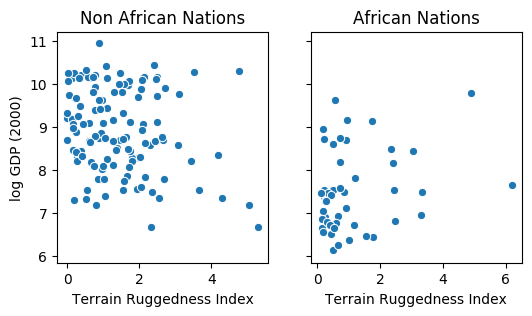

In [4]:
# two-dimensional visualization via two distinct groups
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")
sns.scatterplot(african_nations["rugged"], african_nations["rgdppc_2000"], ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

- We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index. We will create a trivial class called PyroModule[nn.Linear] that subclasses PyroModule and torch.nn.Linear. PyroModule is very similar to PyTorch’s nn.Module, but additionally supports Pyro primitives as attributes that can be modified by Pyro’s effect handlers (see the next section on how we can have module attributes that are pyro.sample primitives). 

- Some general notes:
  - Learnable parameters in PyTorch modules are instances of nn.Parameter, in this case the weight and bias parameters of the nn.Linear class. When declared inside a PyroModule as attributes, these are automatically registered in Pyro’s param store. While this model does not require us to constrain the value of these parameters during optimization, this can also be easily achieved in PyroModule using the PyroParam statement.
  -Note that while the forward method of PyroModule[nn.Linear] inherits from nn.Linear, it can also be easily overridden. e.g. in the case of logistic regression, we apply a sigmoid transformation to the linear predictor.

In [0]:
from torch import nn
from pyro.nn import PyroModule
# check if Pyro nn.Linear model is a sub-class of nn.Linear and PyroModule
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [6]:
# We use the mean squared error (MSE) as our loss and Adam as our optimizer from the torch.optim module. 
# We would like to optimize the parameters of our model, namely the weight and bias parameters of the network, 
# which corresponds to our regression coefficents and the intercept.

# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values, dtype=torch.float)
# turn input data into tensor
x_data, y_data = data[:, :-1], data[:, -1]
print(x_data[:5])
print(y_data[:5])

tensor([[1.0000, 0.8580, 0.8580],
        [0.0000, 3.4270, 0.0000],
        [0.0000, 0.7690, 0.0000],
        [0.0000, 0.7750, 0.0000],
        [0.0000, 2.6880, 0.0000]])
tensor([7.4926, 8.2169, 9.9333, 9.4070, 7.7923])


In [7]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss
train()

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3124.7378
[iteration 0100] loss: 1600.7030
[iteration 0150] loss: 1102.5784
[iteration 0200] loss: 829.2407
[iteration 0250] loss: 634.1833
[iteration 0300] loss: 485.6821
[iteration 0350] loss: 374.5699
[iteration 0400] loss: 294.7163
[iteration 0450] loss: 239.7163
[iteration 0500] loss: 203.3574
[iteration 0550] loss: 180.2554
[iteration 0600] loss: 166.1327
[iteration 0650] loss: 157.8207
[iteration 0700] loss: 153.1092
[iteration 0750] loss: 150.5364
[iteration 0800] loss: 149.1829
[iteration 0850] loss: 148.4970
[iteration 0900] loss: 148.1622
[iteration 0950] loss: 148.0049
[iteration 1000] loss: 147.9338
[iteration 1050] loss: 147.9028
[iteration 1100] loss: 147.8899
[iteration 1150] loss: 147.8846
[iteration 1200] loss: 147.8826
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94786

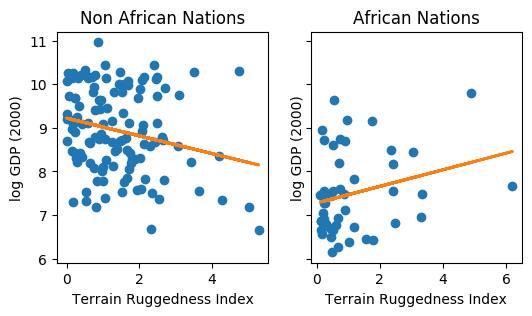

In [8]:
# fit visualization
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]

ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

#### **Bayesian Regression with Pyro’s Stochastic Variational Inference (SVI)**

- In order to make our linear regression Bayesian, we need to put priors on the parameters w and b. These are distributions that represent our prior belief about reasonable values for w and b (before observing any data).
- Making a Bayesian model for linear regression is very intuitive using PyroModule as earlier. Note the following:
  - The BayesianRegression.forward method specifies the generative process. We generate the mean value of the response by calling the linear module (which, as you saw, samples the weight and bias parameters from the prior and returns a value for the mean response). Finally we use the obs argument to the pyro.sample statement to condition on the observed data y_data with a learned observation noise sigma. The model returns the regression line given by the variable mean.


In [0]:
from pyro.nn import PyroSample

In [10]:
# nn.Linear: Applies a linear transformation to the incoming data: y = xA^T + b
m = nn.Linear(2, 3)
input_ = torch.randn(6, 2)
output = m(input_)
print(output.size())
print(output)

torch.Size([6, 3])
tensor([[ 1.3022,  0.4144,  0.0826],
        [-0.3320, -0.1006,  0.3380],
        [ 0.4853, -0.0099,  0.2252],
        [ 0.2930,  0.2102,  0.2301],
        [ 1.4662,  0.3729,  0.0653],
        [ 0.4809,  0.1777,  0.2090]], grad_fn=<AddmmBackward>)


In [0]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        # These statements allow us to place a prior over the weight and bias parameters, 
        # instead of treating them as fixed learnable parameters. 
        # For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    # specify the generative process
    # generate the mean value of the response by calling the linear module 
    # (which, as you saw, samples the weight and bias parameters from the prior and returns a value for the mean response)
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        # Remove single-dimensional entries from the shape of an array
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [0]:
# First use an auto-guide to do inference - Stochastic Variational Inference (SVI)
# Find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior.

# Use the AutoDiagonalNormal guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, 
# i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see in Part II). 
# Under the hood, this defines a guide that uses a Normal distribution with learnable parameters corresponding to each sample statement in the model. 
# e.g. in our case, this distribution should have a size of (5,) correspoding to the 3 regression coefficients for each of the terms, 
# and 1 component contributed each by the intercept term and sigma in the model.
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [13]:
# Optimizing the Evidence Lower Bound
# We will use stochastic variational inference (SVI) (for an introduction to SVI, see SVI Part I) for doing inference. 
# Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, 
# with the difference that in this case, we’ll use the Evidence Lower Bound (ELBO) objective 
# instead of the MSE loss by constructing a Trace_ELBO object that we pass to SVI.
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.8538
[iteration 0101] loss: 3.7030
[iteration 0201] loss: 3.3925
[iteration 0301] loss: 3.2693
[iteration 0401] loss: 2.9952
[iteration 0501] loss: 2.6224
[iteration 0601] loss: 2.0546
[iteration 0701] loss: 1.4772
[iteration 0801] loss: 1.4652
[iteration 0901] loss: 1.4633
[iteration 1001] loss: 1.4825
[iteration 1101] loss: 1.4789
[iteration 1201] loss: 1.4464
[iteration 1301] loss: 1.4656
[iteration 1401] loss: 1.4661


In [14]:
# We can examine the optimized parameter values by fetching from Pyro’s param store
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2423, -1.8192, -0.1705,  0.3796,  9.1807])
AutoDiagonalNormal.scale tensor([0.0630, 0.1278, 0.0410, 0.0751, 0.0672])


In [15]:
# To look at the distribution of the latent parameters more clearly, 
# we can make use of the AutoDiagonalNormal.quantiles method which will unpack the latent samples from the autoguide, 
# and automatically constrain them to the site’s support (e.g. the variable sigma must lie in (0, 10)). 

# We see that the median values for the parameters are quite close to the Maximum Likelihood point estimates we obtained from our first model.
guide.quantiles([0.25, 0.5, 0.75])

{'linear.bias': [tensor([9.1354]), tensor([9.1807]), tensor([9.2261])],
 'linear.weight': [tensor([[-1.9054, -0.1982,  0.3289]]),
  tensor([[-1.8192, -0.1705,  0.3796]]),
  tensor([[-1.7330, -0.1429,  0.4302]])],
 'sigma': [tensor(0.9239), tensor(0.9601), tensor(0.9976)]}

In [0]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [0]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

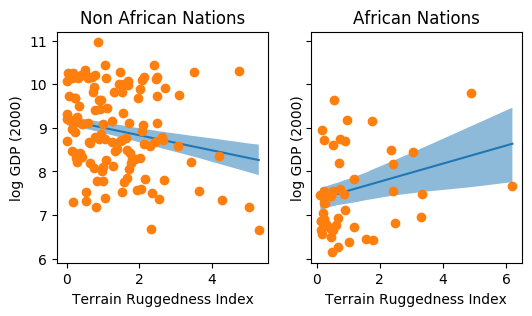

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

# Regression line 90% CI
ax[0].plot(non_african_nations["rugged"], non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"], african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

#### **Bayesian Regression - Inference Algorithms (Part 2)**
- https://pyro.ai/examples/bayesian_regression_ii.html

In [0]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)

In [0]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [0]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.), constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.), constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [0]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [24]:
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model, guide, optim.Adam({"lr": .05}), loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()

num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.467590510845
Elbo loss: 415.81694465875626
Elbo loss: 250.71917921304703
Elbo loss: 247.1945726275444
Elbo loss: 249.20040315389633
Elbo loss: 250.96485948562622
Elbo loss: 249.35092496871948
Elbo loss: 248.78315621614456
Elbo loss: 248.62140625715256
Elbo loss: 250.42744302749634


In [0]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [26]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values)

Site: a
      mean       std       5%       25%       50%       75%      95%
0  9.17702  0.059607  9.07811  9.140463  9.178211  9.217098  9.27152
Site: bA
       mean       std       5%       25%       50%       75%       95%
0 -1.890622  0.122805 -2.08849 -1.979107 -1.887476 -1.803683 -1.700853
Site: bR
       mean       std       5%       25%       50%       75%       95%
0 -0.157847  0.039538 -0.22324 -0.183673 -0.157873 -0.133102 -0.091713
Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.304515  0.067683  0.194583  0.259464  0.304907  0.348932  0.415127
Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.902898  0.047971  0.824166  0.870317  0.901981  0.935171  0.981577


#### **Variational Autoencoders**
- https://pyro.ai/examples/vae.html

In [0]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [0]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x.float()))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [0]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [0]:
vae = VAE()

In [0]:
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [0]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [0]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [0]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 20
TEST_FREQUENCY = 5

In [36]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()
# setup the VAE
vae = VAE(use_cuda=USE_CUDA)
# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw





Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
[epoch 000]  average training loss: 191.0216
[epoch 000] average test loss: 156.0872
[epoch 001]  average training loss: 146.8141
[epoch 002]  average training loss: 133.2540
[epoch 003]  average training loss: 124.6775
[epoch 004]  average training loss: 119.5152
[epoch 005]  average training loss: 116.1240
[epoch 005] average test loss: 113.7908
[epoch 006]  average training loss: 113.7285
[epoch 007]  average training loss: 112.0445
[epoch 008]  average training loss: 110.7292
[epoch 009]  average training loss: 109.7455
[epoch 010]  average training loss: 108.9070
[epoch 010] average test loss: 107.7720
[epoch 011]  average training loss: 108.2513
[epoch 012]  average training loss: 107.6953
[epoch 013]  average training loss: 107.2849
[epoch 014]  average training loss: 106.8870
[epoch 015]  average training loss: 106.4983
[epoch 015] average test loss: 105.9786
[epoch 016]  average tr

#### **BCCA Model via Normalizing flow estimation**

In [0]:
import numpy as np
import math
from scipy.stats import ortho_group

# We use the pyro.generic interface to support dynamic choice of backend.
from pyro.generic import pyro_backend
from pyro.generic import distributions as dist
from pyro.generic import infer, optim, pyro

import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
# arguments used to instantiate PyTorch optimizers for all the parameters
from pyro.optim import Adam
# Prediction
from pyro.infer import Predictive

import torch
import pyro
import pyro.optim
import pyro.infer
import pyro.contrib.autoguide as autoguide
import numpy as np
import time as tm

from pyro.poutine import trace
from pprint import pprint

In [0]:
# data generation
N = 2000 # sample size in each fake dataset
D = [6, 8] # columns size for two datasets
K = 10 # no. of latent dimensions prior(actual K is unknown in model)
K_est = 10 # of shared LF to be estimated (actual K is unknown in model)
J = [4, 2] # unshared latent factors dimensions
eps = 0.1 # non-CCA iid error scale

In [0]:
## shared/common factors ##
Z_shared = np.zeros((K, N))
# update by row 
Z_shared[0,] = np.sin(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[1,] = np.cos(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[2,] = np.random.normal(0, 1, N)
Z_shared[3,] = 2*np.array([i for i in range(1, N+1)])/N - 0.5

m = ortho_group.rvs(dim=J[0]) # orthonormal matrix
Sig_1 = np.matmul(np.matmul(m, np.diag(10*np.random.random(J[0]))), np.transpose(m))
n = ortho_group.rvs(dim=J[1])
Sig_2 = np.matmul(np.matmul(n, np.diag(10*np.random.random(J[1]))), np.transpose(n))

# generate unshared factors
Z_1 = np.transpose(np.random.multivariate_normal([0]*J[0], Sig_1, N))
Z_2 = np.transpose(np.random.multivariate_normal([0]*J[1], Sig_2, N))

A_1 = np.random.randint(-10, 10, size=(D[0], K))
A_2 = np.random.randint(-10, 10, size=(D[1], K)) + 0.5
# generate weight matrix for Z unshared
B_1 = np.random.randint(-10, 0, size=(D[0], J[0]))/10
B_2 = np.random.randint(0, 10, size=(D[1], J[1]))/10

X_1 = np.transpose(np.random.normal(0, eps, D[0]*N).reshape((D[0], N)) + np.matmul(A_1, Z_shared) + np.matmul(B_1, Z_1))
X_2 = np.transpose(np.random.normal(0, eps, D[1]*N).reshape((D[1], N)) + np.matmul(A_2, Z_shared) + np.matmul(B_2, Z_2))
data = np.concatenate((X_1, X_2), axis=1)

In [40]:
data = torch.tensor(data)
data = data.transpose_(0, 1)
N = data.shape[1] # no. of observations
print(N)

2000


In [41]:
# function definition and linear flows pre-test
# return multiple values from a function in Python
def test2():
    return 'abc', 100, [0, 1, 2]
a, b, c = test2()
print(a)
print(b)
print(c)

# nn.Linear: Applies a linear transformation to the incoming data: y = xA^T + b
m = nn.Linear(2, 3) # [N, output_dim]
input_ = torch.randn(6, 2) # Z = [K, N]
output = m(input_)
print(output.size())
print(output)
# f(x) = ln(1+exp(x)) 
positive = nn.Softplus()
output = positive(output)
print(output.size())
print(output)
print(torch.ones([6, 3]) + output)

abc
100
[0, 1, 2]
torch.Size([6, 3])
tensor([[ 0.0469,  0.1575,  0.4335],
        [-0.1223, -0.8577,  0.8164],
        [ 0.1436,  0.6345,  0.1404],
        [ 0.0724,  0.1800,  0.2821],
        [-0.0501, -0.0995,  0.8865],
        [ 0.0988,  0.4249,  0.2845]], grad_fn=<AddmmBackward>)
torch.Size([6, 3])
tensor([[0.7169, 0.7750, 0.9332],
        [0.6339, 0.3536, 1.1824],
        [0.7675, 1.0599, 0.7658],
        [0.7300, 0.7872, 0.8441],
        [0.6684, 0.6446, 1.2316],
        [0.7438, 0.9280, 0.8455]], grad_fn=<SoftplusBackward>)
tensor([[1.7169, 1.7750, 1.9332],
        [1.6339, 1.3536, 2.1824],
        [1.7675, 2.0599, 1.7658],
        [1.7300, 1.7872, 1.8441],
        [1.6684, 1.6446, 2.2316],
        [1.7438, 1.9280, 1.8455]], grad_fn=<AddBackward0>)


In [0]:
class Flows(nn.Module):
  def __init__(self, z_dim, hidden_dim):
    super(Flows, self).__init__()
    # setup the two linear transformations used for mean and variance
    # mean and variance share same hidden_dim here
    # here z_dim represents 2nd dimension - multiplication check
    self.fc1_mean = nn.Linear(z_dim, hidden_dim)
    self.fc2_mean = nn.Linear(hidden_dim, z_dim)
    self.fc1_var = nn.Linear(z_dim, hidden_dim)
    self.fc2_var = nn.Linear(hidden_dim, z_dim)
    # setup the non-linearities - in case needed
    # f(x) = ln(1+exp(x))
    self.softplus = nn.Softplus()
    # f(x) = exp(x)/(1+exp(x))
    self.sigmoid = nn.Sigmoid()
  
  # can separate as forward_mean and forward_var if needed
  def forward_mean(self, z):
    # define the forward computation on the latent z
    # first compute the z_mean
    z_mean_par = self.fc2_mean(self.fc1_mean(z)) # unconstrained
    # return parameters for Normal distribution sampling
    # each is of size K x N
    return z_mean_par

  def forward_var(self, z):
    # variance positive
    # sigmoid would limit from 0 to 1
    z_var_par = self.sigmoid(self.fc2_var(self.fc1_var(z)))
    z_var_par = self.softplus(z_var_par)
    # return parameters for Normal distribution sampling
    # each is of size K x N
    return z_var_par

In [0]:
# Combination of BCCA and Flows Module
class BCCA_Flows(nn.Module):
  # by default our latent space is K x N - dimensional
  # and we use 200 hidden units
  def __init__(self, z_dim=N, hidden_dim=100, use_cuda=False):
    super(BCCA_Flows, self).__init__()
    # create Flows networks for z_mean and z_var
    self.flows = Flows(z_dim, hidden_dim)
    if use_cuda:
      # calling cuda() here will put all the parameters of
      # the encoder and decoder networks into gpu memory
      self.cuda()
    self.use_cuda = use_cuda
    self.z_dim = z_dim
  
  # define the model function
  # almost the same as previous BCCA estimation
  def model(self, data):
    # ARD prior
    tau = pyro.sample('tau', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([K, 2]).independent(2))  
    sig = pyro.sample('sig', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([2]).independent(1)) 
    Z = pyro.sample("Z", dist.Normal(0.0, 1.0).expand([K, self.z_dim]).independent(2))
    # weight matrix
    W1 = pyro.sample("W1", dist.Normal(torch.tensor(0.0), tau[:, 0].sqrt().reciprocal()).expand_by([D[0]]).independent(2))
    W2 = pyro.sample("W2", dist.Normal(torch.tensor(0.0), tau[:, 1].sqrt().reciprocal()).expand_by([D[1]]).independent(2))
    # dataset sampling
    pyro.sample("dataset_1", dist.Normal(torch.mm(W1, Z), sig[0]).independent(2), obs=data[:D[0], :])
    pyro.sample("dataset_2", dist.Normal(torch.mm(W2, Z), sig[1]).independent(2), obs=data[D[0]:, :])
  
  # define the guide (i.e. variational distribution) q(z|x)
  def guide_flexible(self, data):
    # register PyTorch module `decoder` with Pyro
    pyro.module("flows", self.flows)
    # sampling
    valid_range = constraints.greater_than(0.0)

    tau_alpha = pyro.param("tau_alpha", torch.tensor(0.).expand([K, 2])) # positive
    tau_beta = pyro.param("tau_beta", torch.tensor(1.).expand([K, 2]), constraint=valid_range) # positive
    tau_q = pyro.sample('tau', dist.LogNormal(tau_alpha, tau_beta).independent(2))

    sig_location = pyro.param("sig_location", torch.tensor(0.).expand([2])) # positive
    sig_scale = pyro.param("sig_scale", torch.tensor(1.).expand([2]), constraint=valid_range) # positive 
    pyro.sample('sig', dist.LogNormal(sig_location, sig_scale).independent(1))

    # use the Flows to get the parameters used to define q(z|x)
    Z_flow_input_mean = pyro.param("Z_flow_input_mean", torch.tensor(0.0).expand([K, self.z_dim]))
    Z_flow_input_var = pyro.param("Z_flow_input_var", torch.tensor(1.0).expand([K, self.z_dim]))
    # Z_mean, Z_var = self.flows.forward(Z_flow_input)
    Z_mean = self.flows.forward_mean(Z_flow_input_mean)
    Z_var = self.flows.forward_var(Z_flow_input_var)
    pyro.sample("Z", dist.Normal(Z_mean, Z_var).independent(2))

    W1_mean = pyro.param("W1_mean", torch.tensor(0.0).expand([D[0], K]))
    W2_mean = pyro.param("W2_mean", torch.tensor(0.0).expand([D[1], K]))
    pyro.sample("W1", dist.Normal(W1_mean, tau_q[:, 0].sqrt().reciprocal()).independent(2)) # D[0]*K
    pyro.sample("W2", dist.Normal(W2_mean, tau_q[:, 1].sqrt().reciprocal()).independent(2)) # D[1]*K

In [0]:
from pyro.poutine import trace
from pprint import pprint
from pyro.poutine import replay

# class module setup
bcca_flows = BCCA_Flows()
# learning rate under flows needs to be small
optimizer = Adam({"lr": 1e-2})
svi = SVI(bcca_flows.model, bcca_flows.guide_flexible, optimizer, loss=Trace_ELBO())

In [132]:
# clear-up
pyro.clear_param_store()
# training with given max steps
# parameters setup
NUM_STEPS = 15000
BACK_STEPS = 1000
decay_threshold = 1e-5
losses = []

pyro.clear_param_store()
start = tm.time()
for step in range(NUM_STEPS):
    losses.append(svi.step(data))
    if step > BACK_STEPS:
      # quite stable over BACK_STEPS steps
      if np.abs((losses[step-BACK_STEPS] - losses[step])/losses[step-BACK_STEPS]) <= decay_threshold:
        print('Losses converged with ll %.3f at iteration %d'%(losses[-1], step))
        break
    if step % 500 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")
print(f"\nfinished in {tm.time() - start:.2f} seconds")

step:     0, ELBO loss: 6904664.56
step:   500, ELBO loss: 136273.97
step:  1000, ELBO loss: 114411.09
step:  1500, ELBO loss: 165862.71
step:  2000, ELBO loss: 107244.88
step:  2500, ELBO loss: 97045.30
step:  3000, ELBO loss: 93211.55
step:  3500, ELBO loss: 92417.41
step:  4000, ELBO loss: 91716.24
step:  4500, ELBO loss: 96108.83
step:  5000, ELBO loss: 95498.09
step:  5500, ELBO loss: 93326.80
step:  6000, ELBO loss: 97534.69
step:  6500, ELBO loss: 91316.01
step:  7000, ELBO loss: 90974.71
step:  7500, ELBO loss: 92236.76
step:  8000, ELBO loss: 95715.87
Losses converged with ll 90844.185 at iteration 8257

finished in 218.00 seconds


In [133]:
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

flows$$$fc1_mean.weight:
Parameter containing:
tensor([[-0.0076,  0.0100,  0.0091,  ..., -0.0117, -0.0107,  0.0361],
        [-0.0181, -0.0012,  0.0209,  ...,  0.0205, -0.0288,  0.0171],
        [ 0.0133, -0.0145, -0.0265,  ..., -0.0060, -0.0304, -0.0417],
        ...,
        [-0.0351, -0.0156,  0.0193,  ..., -0.0385, -0.0211, -0.0062],
        [-0.0226, -0.0139,  0.0005,  ..., -0.0028,  0.0081,  0.0142],
        [ 0.0101, -0.0057,  0.0229,  ..., -0.0242, -0.0032, -0.0894]],
       requires_grad=True)

flows$$$fc1_mean.bias:
Parameter containing:
tensor([-5.5401e-03, -3.0044e-02,  8.6469e-03, -4.6594e-03, -1.0605e-02,
        -2.6715e-02, -1.1119e-02,  7.5400e-03,  3.3224e-03,  3.7583e-03,
        -1.7687e-02, -4.2904e-01,  1.3544e-02, -5.3631e-02, -8.0565e-03,
         2.1097e-05, -1.8203e-02, -1.1868e-02, -1.9048e-02, -3.8203e-02,
        -7.8216e-02,  1.7794e-02,  4.5972e-02, -2.5954e-03,  6.7145e-03,
         1.3995e-02, -1.8567e-03,  4.5762e-03, -8.3179e-03,  1.4880e-02,
        

In [0]:
samples_dic = Predictive(bcca_flows.model, guide=bcca_flows.guide_flexible, num_samples=1000)(data)
Z_hat = samples_dic['Z'].mean(0) 
tau_hat = samples_dic['tau'].mean(0)
sig_hat = samples_dic['sig'].mean(0) 
W1_hat = samples_dic['W1'].mean(0)
W2_hat = samples_dic['W2'].mean(0)

In [135]:
# error
# reconstruct datasets
X_1_hat = torch.mm(W1_hat, Z_hat) # D[0]*N
X_2_hat = torch.mm(W2_hat, Z_hat) # D[1]*N
print("Reconstruction loss on shared components - MSE")
X_1_shared_loss = np.mean((np.transpose(np.matmul(A_1, Z_shared)) - np.transpose(X_1_hat.detach().numpy()))**2)
print("X_1_shared_loss: ", X_1_shared_loss)
X_2_shared_loss = np.mean((np.transpose(np.matmul(A_2, Z_shared)) - np.transpose(X_2_hat.detach().numpy()))**2)
print("X_2_shared_loss: ", X_2_shared_loss)
print("Automatic relevance detection (ARD) ")
print("Large tau == irrelevant latent component for dataset")
print("Sections 4.1, 4.2")
print(tau_hat)
print(sig_hat)

Reconstruction loss on shared components - MSE
X_1_shared_loss:  3.847743505741707
X_2_shared_loss:  3.1813673615422347
Automatic relevance detection (ARD) 
Large tau == irrelevant latent component for dataset
Sections 4.1, 4.2
tensor([[ 7.6535,  9.6853],
        [14.7279,  9.3066],
        [ 7.7964, 10.7711],
        [10.1691, 11.9627],
        [ 7.8110, 11.1883],
        [10.4938,  8.7672],
        [ 7.9805, 10.9739],
        [ 9.5203, 16.0635],
        [ 9.1619, 10.2057],
        [11.7940,  9.9497]], grad_fn=<MeanBackward1>)
tensor([4.8139, 4.1565], grad_fn=<MeanBackward1>)
